In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# data preprocess tools
from nltk import data
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer


In [2]:
import stanza
#stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

2021-11-25 21:57:15 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-11-25 21:57:15 INFO: Use device: cpu
2021-11-25 21:57:15 INFO: Loading: tokenize
2021-11-25 21:57:16 INFO: Loading: ner
2021-11-25 21:57:16 INFO: Done loading processors!


In [3]:
data = pd.read_excel('./dataset.xlsx')
data

,content,label
0,@Ricardo70078700 I have a big problem buying f...,0
1,RT @tconnellyRTE : 6/ “One colleague working o...,0
2,RT @joncstone : In case you missed this from m...,0
3,RT @AlexandravonNah : EU climate chief: 'We ne...,0
4,RT @Fourens__ : My colleague just told me she ...,0
...,...,...
637,"My boss's dog married my dog, and he covered m...",0
638,"My neighbor is a boss, but he is friendly to t...",0
639,Looking forward to the department dinner this ...,0
640,My boss is shameless,1


In [4]:
print('Contain {} posts'.format(data.shape[0]))
print('non-sensitive: {}'.format(data['label'].value_counts()[0]))
print('sensitive: {}'.format(data['label'].value_counts()[1]))

Contain 642 posts
non-sensitive: 370
sensitive: 272


<AxesSubplot:>

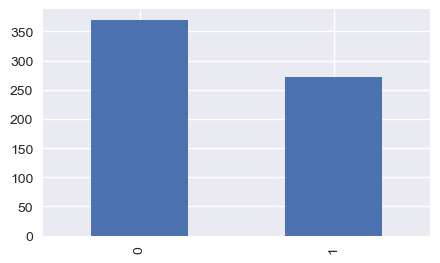

In [5]:
plt.style.use('seaborn')
plt.figure(figsize=(5,3), dpi=100)
data['label'].value_counts().plot(kind='bar')

In [6]:
data['content'] = data['content'].str.lower()
data.head()

,content,label
0,@ricardo70078700 i have a big problem buying f...,0
1,rt @tconnellyrte : 6/ “one colleague working o...,0
2,rt @joncstone : in case you missed this from m...,0
3,rt @alexandravonnah : eu climate chief: 'we ne...,0
4,rt @fourens__ : my colleague just told me she ...,0


In [7]:
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))

data.head()

,content,label
0,i have a big problem buying from all the metho...,0
1,rt : 6/ “one colleague working on ni was nearl...,0
2,rt : in case you missed this from my colleague,0
3,rt : eu climate chief: 'we need to be more amb...,0
4,rt : my colleague just told me she bought a ho...,0


In [8]:
stop_words = set(stopwords.words('english'))
stop_words.add('rt')

In [9]:
def text_process(text):
    tokenizer = RegexpTokenizer('[a-z0-9]+')
    token = tokenizer.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words]
    return token

In [10]:
data['content'] = data['content'].apply(text_process)

In [11]:
data

,content,label
0,"[big, problem, buying, method, country, accept...",0
1,"[6, one, colleague, working, ni, wa, nearly, t...",0
2,"[case, missed, colleague]",0
3,"[eu, climate, chief, need, ambitious, frans, t...",0
4,"[colleague, told, bought, house, wa, gifted, 3...",0
...,...,...
637,"[bos, dog, married, dog, covered, dog, food, y...",0
638,"[neighbor, bos, friendly, people, community]",0
639,"[looking, forward, department, dinner, friday]",0
640,"[bos, shameless]",1


In [12]:
X = data['content']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 136)

In [13]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [14]:
train

,content,label
70,"[wife, mother, nana, food, service, supervisor...",0
126,"[urgent, job, seeker, need, employability, boo...",0
484,"[want, get, fired, huh]",1
21,"[bus, company, also, starting, report, shortag...",0
538,"[happy, birthday, super, bos, 411]",0
...,...,...
631,"[bos, said, would, give, raise, next, month, 2...",1
585,"[supervisor, disrespectfully, body, shamed, wo...",1
54,"[ever, interested, seeing, work, contacting, s...",0
233,"[arabic, banner, protest, say, governed, el, s...",0


0    285
1    228
Name: label, dtype: int64


<AxesSubplot:>

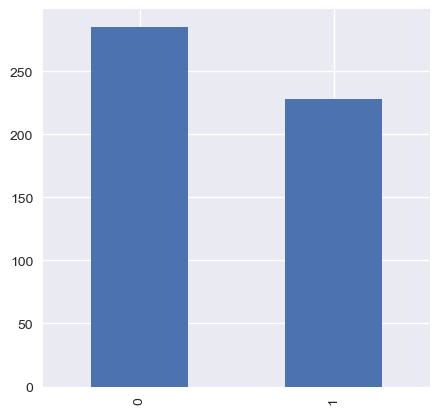

In [15]:
print(train['label'].value_counts())
plt.figure(figsize=(5,5), dpi=100)
train['label'].value_counts().plot(kind='bar')

0    85
1    44
Name: label, dtype: int64


<AxesSubplot:>

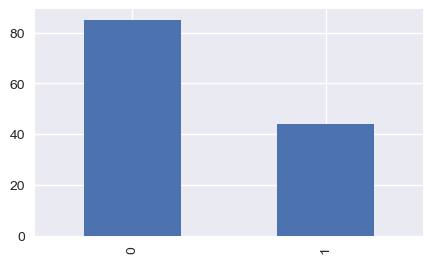

In [16]:
print(test['label'].value_counts())
plt.figure(figsize=(5,3), dpi=100)
test['label'].value_counts().plot(kind='bar')

In [17]:
non_sensitive_train = train[train['label'] == 0]
sensitive_train = train[train['label'] == 1]

In [18]:
non_sensitive_train

,content,label
70,"[wife, mother, nana, food, service, supervisor...",0
126,"[urgent, job, seeker, need, employability, boo...",0
21,"[bus, company, also, starting, report, shortag...",0
538,"[happy, birthday, super, bos, 411]",0
260,"[hello, manager, would, love, would, really, h...",0
...,...,...
10,"[big, smile, wednesday, love, colleague, sent,...",0
63,"[going, make, sure, kyrsten, sinema, primaried...",0
54,"[ever, interested, seeing, work, contacting, s...",0
233,"[arabic, banner, protest, say, governed, el, s...",0


In [19]:
# non_sensitive_train_part = non_sensitive_train['content'].sample(139, random_state=42)
# sensitive_train_part = sensitive_train['content'].sample(139, random_state=42)

non_sensitive_trainset = non_sensitive_train['content']
sensitive_trainset = sensitive_train['content']

vocablist = []
for i in pd.concat([non_sensitive_trainset, sensitive_trainset]):
    vocablist += i

In [20]:
vocablist

['wife',
 'mother',
 'nana',
 'food',
 'service',
 'supervisor',
 'ha',
 'back',
 'problem',
 'work',
 'much',
 'give',
 'back',
 'share',
 'never',
 'taking',
 'time',
 'pamper',
 'keep',
 'best',
 'feeling',
 'urgent',
 'job',
 'seeker',
 'need',
 'employability',
 'boost',
 'get',
 'cv',
 'reviewed',
 'free',
 'hr',
 'professional',
 'info',
 'bus',
 'company',
 'also',
 'starting',
 'report',
 'shortage',
 'driver',
 'bus',
 'driver',
 'leaving',
 'drive',
 'hgvs',
 'http',
 'co',
 'ycou1hi1pj',
 'happy',
 'birthday',
 'super',
 'bos',
 '411',
 'hello',
 'manager',
 'would',
 'love',
 'would',
 'really',
 'help',
 'lot',
 'apply',
 'scholarship',
 'following',
 'axie',
 'month',
 'wa',
 'determined',
 'invest',
 'wa',
 'fired',
 'job',
 'would',
 'help',
 'lot',
 'get',
 'ahead',
 'happy',
 'wrap',
 'medical',
 'surgical',
 'nurse',
 'week',
 'november',
 '1',
 '7',
 'appreciate',
 'backbone',
 'hospital',
 'year',
 'thank',
 'flexibility',
 'fortitude',
 '2022',
 'thank',
 'helpin

In [21]:
trainset_texts = [' '.join(content) for content in np.concatenate((non_sensitive_trainset.values, sensitive_trainset.values))]

train_all_texts = [' '.join(content) for content in train['content']]

test_all_texts = [' '. join(content) for content in test['content']]


In [22]:
trainset_texts

['wife mother nana food service supervisor ha back problem work much give back share never taking time pamper keep best feeling',
 'urgent job seeker need employability boost get cv reviewed free hr professional info',
 'bus company also starting report shortage driver bus driver leaving drive hgvs http co ycou1hi1pj',
 'happy birthday super bos 411',
 'hello manager would love would really help lot apply scholarship following axie month wa determined invest wa fired job would help lot get ahead',
 'happy wrap medical surgical nurse week november 1 7 appreciate backbone hospital year thank flexibility fortitude 2022 thank helping train onboard new team member',
 'prepared still post country meet salary demand strike service country',
 'associate british value tolerance fairness newer british way value selfishness arrogance plain racist behaviour unfortunately union flag longer positive acceptable symbol',
 'waiting miracle grandmother surgery cost salary enough surgery hopefully good p

In [23]:
cv = CountVectorizer()
trainset_fit = cv.fit(trainset_texts)
train_all_count = cv.transform(train_all_texts)
test_all_count = cv.transform(test_all_texts)

In [24]:
train_all_count

<513x3477 sparse matrix of type '<class 'numpy.int64'>'
	with 7680 stored elements in Compressed Sparse Row format>

In [25]:
tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)
test_tfidf_matrix = tfidf.fit_transform(test_all_count)

In [26]:
train_tfidf_matrix

<513x3477 sparse matrix of type '<class 'numpy.float64'>'
	with 7680 stored elements in Compressed Sparse Row format>

In [27]:
model = MultinomialNB(alpha=1.1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)

In [28]:
model.score(test_tfidf_matrix, y_test)

0.8372093023255814

In [29]:
pred = model.predict(test_tfidf_matrix)
acc = 1 - np.sum(np.abs(y_test - pred)) / len(y_test)
print(acc)

0.8372093023255813


In [30]:
from sklearn import datasets,linear_model,svm

def test_LinearSVC(*data):
    x_train,x_test,y_train,y_test=data
    cls=svm.LinearSVC()
    cls.fit(x_train,y_train)
    print('SVM')
    print('Coefficients:%s, intercept %s'%(cls.coef_,cls.intercept_))
    print('Score: %.2f' % cls.score(x_test, y_test))


test_LinearSVC(train_tfidf_matrix,test_tfidf_matrix,y_train,y_test)   

SVM
Coefficients:[[ 0.31053967  0.31965062  0.55925393 ... -0.10931953  0.06832834
   0.20495866]], intercept [-0.25480654]
Score: 0.76


In [31]:
def test_SVC_Linear(*data):
    x_train,x_test,y_train,y_test=data
    cls=svm.SVC(kernel='linear')
    cls.fit(x_train,y_train)
    print('non-linear SVM')
    # print('Coefficients:%s, intercept %s'%(cls.coef_,cls.intercept_))
    print('Score: %.2f' % cls.score(x_test, y_test))

test_SVC_Linear(train_tfidf_matrix,test_tfidf_matrix,y_train,y_test)

non-linear SVM
Score: 0.74


In [32]:
from sklearn.neighbors import KNeighborsClassifier
#KNN, neuighbors=10
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(train_tfidf_matrix, y_train)
knn.score(test_tfidf_matrix, y_test)

0.7286821705426356

In [33]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time

NBM = [SVC(kernel='linear', C=0.5), 
       SVC(kernel='rbf', C=0.5, gamma='auto'),
       SVC(kernel='poly', C=0.5, degree=3), 
       KNeighborsClassifier(n_neighbors=11), 
       MultinomialNB(),
       DecisionTreeClassifier(max_depth=15, min_samples_split=5), #防止过拟合将树深设为10
       AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, min_samples_split=5),
                                                 n_estimators=200, learning_rate=0.8),#选择决策树，迭代000次，学习率为0.8
       RandomForestClassifier(n_estimators= 200, max_depth=10)]
NAME= ["LINEAR","RBF","poly", "KNN_N11", "MNB","DCT", "Boosting_Ada", "Bagging_RF"]
for itr, itrname in zip(NBM, NAME):
    #训练过程
    print("Training...")
    t1 = time.perf_counter()
    itr.fit(train_tfidf_matrix, y_train)
    t2 = time.perf_counter()
    print("Applying...")
    y_train_pdt = itr.predict(train_tfidf_matrix)
    t3 = time.perf_counter()
    y_test_pdt = itr.predict(test_tfidf_matrix)

    dts1 = len(np.where(y_train_pdt==y_train)[0])/len(y_train)
    dts2 = len(np.where(y_test_pdt==y_test)[0])/len(y_test)
    
    acc1 = accuracy_score(y_train_pdt, y_train)
    acc2 = accuracy_score(y_test_pdt, y_test)
    
    pre1 = precision_score(y_train_pdt, y_train)
    pre2 = precision_score(y_test_pdt, y_test)
    
    rec1 = recall_score(y_train_pdt, y_train)
    rec2 = recall_score(y_test_pdt, y_test)

    print("model_train：{} accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, time：{:.2f}s".format(itrname, acc1*100, pre1*100, rec1*100, t2 - t1))
    print("model_test：{} accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, time：{:.2f}s".format(itrname, acc2*100, pre2*100, rec2*100, t3 - t2))
    

Training...
Applying...
model_train：LINEAR accuracy:89.669%, precision:77.632%, recall:98.883%, time：0.04s
model_test：LINEAR accuracy:79.845%, precision:56.818%, recall:78.125%, time：0.03s
Training...
Applying...
model_train：RBF accuracy:55.556%, precision:0.000%, recall:0.000%, time：0.03s
model_test：RBF accuracy:65.891%, precision:0.000%, recall:0.000%, time：0.03s
Training...


/Users/yhl125/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Applying...
model_train：poly accuracy:58.285%, precision:6.140%, recall:100.000%, time：0.04s
model_test：poly accuracy:66.667%, precision:2.273%, recall:100.000%, time：0.04s
Training...
Applying...
model_train：KNN_N11 accuracy:74.659%, precision:48.684%, recall:89.516%, time：0.00s
model_test：KNN_N11 accuracy:76.744%, precision:45.455%, recall:76.923%, time：0.02s
Training...
Applying...
model_train：MNB accuracy:98.441%, precision:96.930%, recall:99.550%, time：0.00s
model_test：MNB accuracy:81.395%, precision:68.182%, recall:75.000%, time：0.00s
Training...
Applying...
model_train：DCT accuracy:88.694%, precision:75.439%, recall:98.851%, time：0.01s
model_test：DCT accuracy:72.093%, precision:54.545%, recall:60.000%, time：0.00s
Training...
Applying...
model_train：Boosting_Ada accuracy:100.000%, precision:100.000%, recall:100.000%, time：2.59s
model_test：Boosting_Ada accuracy:60.465%, precision:77.273%, recall:45.333%, time：0.05s
Training...
Applying...
model_train：Bagging_RF accuracy:77.778%, p

In [64]:
clf = MultinomialNB(alpha=1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)
clf.score(test_tfidf_matrix, y_test)

0.77

In [40]:
#text = "@Alice My name is Bob, I work in Microsoft. #highqualityman https:bscn3789de.com"
#text = "Today is my Birthday."
#text = "My salary is $2000 per month"
#text = "My boss Roan is a foolish man"
#text = "I hope Alice get fired tommorrow"
#text = "My workmate is nice"
#text = "My workmate is bad"
#text = "My workmate is shameless"
#text = "My employee John is good"
#text = "My employee John is good but stupid"
#text = "My employee John is stupid, but he pays me a lot"



df = pd.DataFrame({"text":text},index=["0"])

df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))
df['text'] = df['text'].apply(text_process)
print(df['text'])


0    [employee, john, good, stupid]
Name: text, dtype: object


In [47]:
print(df['text'])
text_content = [' '.join(content) for content in df['text']]
print(text_content)
print('---')

text_count = cv.transform(text_content)
print(text_count)
print('+++')
text_tfidf_matrix = tfidf.fit_transform(text_count)
pre = clf.predict(text_tfidf_matrix)
print(pre)


0    [employee, john, good, stupid]
Name: text, dtype: object
['employee john good stupid']
---
  (0, 855)	1
  (0, 1116)	1
  (0, 2490)	1
+++
[1]


In [37]:
doc = nlp(text)
print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in doc.sentences for ent in sent.ents], sep='\n')
for ent in doc.ents:
    if ent.type == 'PERSON':
        print("You may leak 'name' information.")
    if ent.type == 'MONEY':
        print("You may leak 'money' information.")

entity: 2000	type: MONEY
You may leak 'money' information.
